## EfficientDet Demonstration

In [1]:
!pip3 install Pillow==7.1.0

This a demonstration notebook for EfficientDet: Scalable and Efficient Object Detection.    
**Inportant:** Before running this notebook, please ensure that it is placed in the root directory of the repository folder!

In [1]:
import torch

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from model import EfficientDet
from utils import DetectionEvalWrapper, draw_boxes

In [3]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 12)

**First**, we create an EfficientDet model instance with a simple method 'from pretrained' that automatically loads pretrained weights

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EfficientDet.from_pretrained('efficientdet-d2').to(device)

Loaded checkpoint weights/efficientdet-d2.pth


In [5]:
import os

In [6]:
COCO_CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

VOC_CLASSES = ["N/A","person","bird", "cat", "cow", "dog", "horse", "sheep",
               "aeroplane", "bicycle", "boat", "bus", "car", "motorbike", "train",
               "bottle", "chair", "dining table", "potted plant", "sofa", "tv/monitor" 
]

list_ind = [(VOC_CLASSES.index(voc_class) , COCO_CLASSES.index(voc_class)) for voc_class in VOC_CLASSES if voc_class in COCO_CLASSES]


mapping = {}
for i in range(len(list_ind)):
    mapping[list_ind[i][1]] = list_ind[i][0]

In [8]:
# import glob
from glob import glob
import xml.etree.ElementTree as ET

COCO_CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

VOC_CLASSES = ["N/A","person","bird", "cat", "cow", "dog", "horse", "sheep",
               "aeroplane", "bicycle", "boat", "bus", "car", "motorbike", "train",
               "bottle", "chair", "dining table", "potted plant", "sofa", "tv/monitor" 
]



idx_to_class = {i: COCO_CLASSES[i] for i in range(len(COCO_CLASSES))}
voc_idx_to_class = {i: VOC_CLASSES[i] for i in range(len(VOC_CLASSES))}


def predict_bb(image_name):
    wrapper = DetectionEvalWrapper(model, device)
    detections = wrapper([image_name])
    bboxes = []
    scores = []
    categories = []
    score_threshold = 0.3
    objects = []
    
    for detection in detections[0]:
        det = detection.data.cpu().numpy()
        bbox, score, cat = det[:4], det[4], det[5]
        
        class_name = idx_to_class[int(cat)]
        
        if class_name not in VOC_CLASSES:
            continue
        
        cat = VOC_CLASSES.index(class_name)

        # xywh -> xyxy
        bbox = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]
        if score > score_threshold:
            bboxes.append(bbox)
            scores.append(score)
            categories.append(int(cat))
            objects.append({
                'class': voc_idx_to_class[int(cat)],
                'bbox': bbox,
                'score': score
            })
    
    # print("-------------------Predictions-------------------")
    # for cat,bbox,prob in zip(categories,bboxes,scores):
    #     class_name = idx_to_class[cat]
    #     if class_name in VOC_CLASSES:
    #         print(f"class : {idx_to_class[cat]}, bbox : {bbox}, prob : {prob}")
            
    return bboxes, scores, categories, objects



def get_bb_gt(image):
    
    xml_file = image.replace('JPEGImages', 'Annotations').replace('jpg', 'xml')
    objects = []
    
    #code to extract the code from the xml file
    
     # Parse the XML file
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Iterate through each object in the XML
    for obj in root.findall('object'):
        # Get the object's name (class)
        obj_name = obj.find('name').text
        
        # Get the bounding box coordinates
        bbox_xml = obj.find('bndbox')
        xmin = bbox_xml.find('xmin').text
        ymin = bbox_xml.find('ymin').text
        xmax = bbox_xml.find('xmax').text
        ymax = bbox_xml.find('ymax').text
        if obj_name in VOC_CLASSES:
        # Append the details to the objects list
            objects.append({
                'class': obj_name,
                'bbox': [xmin, ymin, xmax, ymax]
            })
        
    return objects
    
    
# images = [ '2007_005304.jpg',
# '2009_002094.jpg',
# '2011_006475.jpg',
# '2011_000611.jpg',
# '2009_004042.jpg',
# '2012_002617.jpg',
# '2008_006902.jpg',
# '2011_003098.jpg',
# '2008_007343.jpg',
# '2008_004347.jpg']   

# counter=0
# for image in reversed(sorted(os.listdir('VOCdevkit/VOC2012/JPEGImages'))):
#     image = f'VOCdevkit/VOC2012/JPEGImages/{image}'
#     print(image)
#     bboxes, scores, categories, objects_predict = predict_bb(image)
#     print("-------------------Predictions-------------------")
#     for obj in objects_predict:
#         print(obj)
#     img = draw_boxes(np.array(Image.open(image)), bboxes, categories, scores,class_names=VOC_CLASSES)
#     bboxes_gt = get_bb_gt(image)
#     print("-------------------Ground Truth-------------------")
#     for obj in bboxes_gt:
#         print(obj)
#     plt.imshow(img)
#     plt.show()
#     counter+=1
#     if counter==20:
#         break


# IOU

In [21]:
def calculate_iou(box1, box2):
    # Calculate intersection coordinates
    
    
    x1 = max(float(box1[0]), box2[0])
    y1 = max(float(box1[1]), box2[1])
    x2 = min(float(box1[2]), box2[2])
    y2 = min(float(box1[3]), box2[3])

    # Calculate intersection area
    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)

    # Calculate areas of bounding boxes
    box1_area = (float(box1[2]) - float(box1[0])) * (float(box1[3]) - float(box1[1]))
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Calculate union area
    union_area = box1_area + box2_area - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area if union_area > 0 else 0
    return iou

def match_boxes(ground_truth, predicted):
    matches = {}
    for pred_box in predicted:
        max_iou = 0
        for gt_box in ground_truth:
            iou = calculate_iou(pred_box['bbox'], gt_box['bbox'])
            if iou > max_iou:
                max_iou = iou
                matches[pred_box] = gt_box
    return matches


def calculate_average_iou(extracted_objects, predicted_objects):
    iou_sum = 0
    total_objects = 0

    for gt_object in extracted_objects:
        gt_box = gt_object['bbox']
        max_iou = 0

        for pred_object in predicted_objects:
            pred_box = pred_object['bbox']
            iou = calculate_iou(gt_box, pred_box)
            if iou > max_iou:
                max_iou = iou

        iou_sum += max_iou
        total_objects += 1

    average_iou = iou_sum / total_objects if total_objects > 0 else 0
    return average_iou

counter = 0

avgs = []

counter=0
for image in reversed(sorted(os.listdir('VOCdevkit/VOC2012/JPEGImages'))):
    image = f'VOCdevkit/VOC2012/JPEGImages/{image}'
    bboxes, scores, categories, predicted_objects = predict_bb(image)
    extracted_objects = get_bb_gt(image)
    avgs.append(calculate_average_iou(extracted_objects, predicted_objects))
    
    counter+=1
    if counter==20:
        break

print("the mIOU for EfficientDet on PascalVoc2012 is:",sum(avgs)/len(avgs))

the mIOU for EfficientDet on PascalVoc2012 is: 0.8359872745909069


# Analysing small object detection

In [9]:
# testing = ['2007_000170.jpg', '2007_000636.jpg', '2007_000661.jpg', '2007_000793.jpg', '2007_000807.jpg', '2007_000822.jpg', '2007_001027.jpg']

# counter=0
# for image in testing:
#     image = f'VOCdevkit/VOC2012/JPEGImages/{image}'
#     print(image)
#     bboxes, scores, categories, objects_predict = predict_bb(image)
#     print("-------------------Predictions-------------------")
#     for obj in objects_predict:
#         print(obj)
#     img = draw_boxes(np.array(Image.open(image)), bboxes, categories, scores,class_names=VOC_CLASSES)
#     bboxes_gt = get_bb_gt(image)
#     print("-------------------Ground Truth-------------------")
#     for obj in bboxes_gt:
#         print(obj)
#     plt.imshow(img)
#     plt.show()


# TIDE analysis

In [8]:
import json

def prepare_json_for_pascal():
    
    images_list = json.load(open('pascal_val2012.json'))['images']
    annotation_list = json.load(open('pascal_val2012.json'))['annotations']
    
    
    counter = 0
    
    l1 = []
    l2 = []
    
    for image , ann in zip(images_list,annotation_list):
        image_name = image['file_name']
        image_id = image['id']
        height = image['height']
        width = image['width']
        
        d1 = {'file_name': image_name, 'height': int(height), 'width': int(width), 'id': image_id}
        l1.append(d1)
        
        iscrowd = ann['iscrowd']
        ann_id = ann['id']
        ignore = ann['ignore']
        
        area = width*height
        
        bboxes, scores, categories, predicted_objects = predict_bb(f'VOCdevkit/VOC2012/JPEGImages/{image_name}')
        
        for bbox , category in zip(bboxes,categories):
            d2 = {'segmentation': [[]], 'area': area, 'iscrowd': iscrowd, 'image_id': image_id, 'bbox': [float(b) for b in bbox], 'category_id': category, 'id': ann_id, 'ignore': ignore}
            l2.append(d2)
        
        counter += 1
        if (counter == 20):
            break
            
    return {'images': l1, 'annotations': l2}

    
data = prepare_json_for_pascal()

with open('bbox_prediction.json', 'w') as f:
    json.dump(data, f)


In [12]:
import json
import tidecv
tide = tidecv.TIDE()


def convert(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return obj

counter = 0

predictions = []
ground_truths = []

counter=0
for image in reversed(sorted(os.listdir('VOCdevkit/VOC2012/JPEGImages'))):
    image_id = image.split('.')[0]
    image = f'VOCdevkit/VOC2012/JPEGImages/{image}'
    bboxes, scores, categories, predicted_objects = predict_bb(image)
    extracted_objects = get_bb_gt(image)
    
    #get the height and width of the image
    img = Image.open(image)
    width, height = img.size
    
    
    # Convert the bounding boxes to the format expected by TIDE
    pred_bboxes = [{'image_id': image_id, 'category_id': VOC_CLASSES.index(pred['class']), 'bbox': [float(coord) for coord in pred['bbox']], 'score': float(pred['score'])} for pred in predicted_objects]
    gt_bboxes = [{'image_id': image_id, 'category_id': VOC_CLASSES.index(gt['class']), 'bbox': [int(coord) for coord in gt['bbox']],"segmentation":[[0]],"iscrowd":None,"width":width,"height":height} for gt in extracted_objects]
        
    predictions.extend(pred_bboxes)
    ground_truths.extend(gt_bboxes)
    
    counter+=1
    if counter==200:
        break
    
    
workaround_list = []
workaround_list.extend({"id": gt["image_id"].split("_")[0] + "_" + gt["image_id"].split("_")[1],"file_name":gt["image_id"] + ".jpg","width":gt["width"],"height":gt["height"]} for gt in ground_truths)
gt_dict = {"images":workaround_list,'annotations': ground_truths}
    
predictions_json = json.dumps(predictions, indent=4)
ground_truths_json = json.dumps(ground_truths, indent=4)
gt_new = json.dumps(gt_dict, indent=4)

# Saving the JSON data to files
with open("predictions.json", "w") as pred_file:
    pred_file.write(predictions_json)

with open("ground_truths.json", "w") as gt_file:
    gt_file.write(ground_truths_json)
    
# save the workaround list
with open("gt.json", "w") as f:
    f.write(gt_new)

-- predictions --

bbox AP @ [50-95]: 6.15
                                         bbox AP @ [50-95]
  Thresh       50       55       60       65       70       75       80       85       90       95  
---------------------------------------------------------------------------------------------------
    AP       7.06     6.99     6.88     6.82     6.70     6.57     6.47     6.06     5.19     2.72  

                         Main Errors
  Type      Cls      Loc     Both     Dupe      Bkg     Miss  
-------------------------------------------------------------
   dAP     0.00     0.74     0.00     0.04     0.79     0.08  

        Special Error
  Type   FalsePos   FalseNeg  
-----------------------------
   dAP       1.85       0.14  



/Users/parthivdholaria/miniforge3/envs/cv/lib/python3.12/site-packages/tidecv/plotting.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=error_dfs['main'], x='Delta mAP', y='Error Type', ax=ax,
/Users/parthivdholaria/miniforge3/envs/cv/lib/python3.12/site-packages/tidecv/plotting.py:156: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=error_dfs['special'], x='Error Type', y='Delta mAP', ax=ax,
/Users/parthivdholaria/miniforge3/envs/cv/lib/python3.12/site-packages/tidecv/plotting.py:161: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['FP', 'FN'])


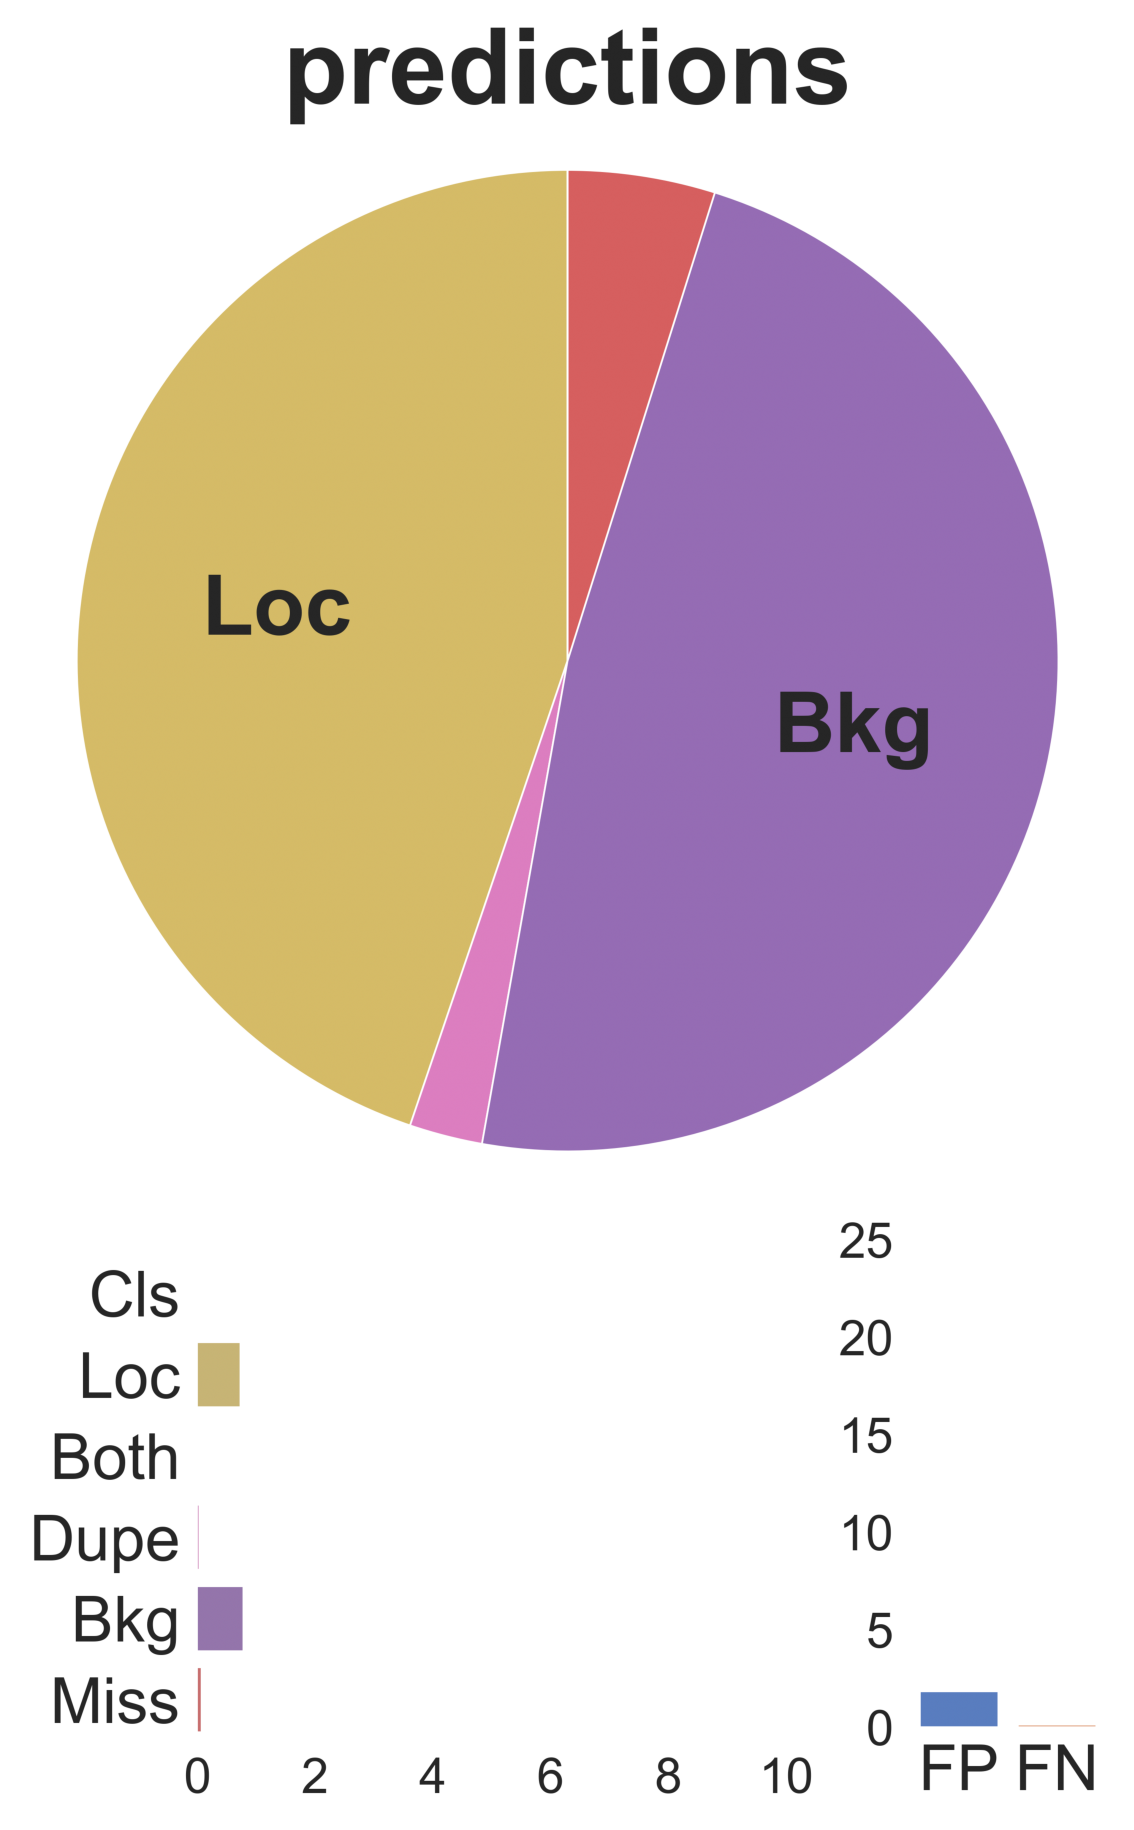

In [13]:
# Import the TIDE evaluation toolkit
from tidecv import TIDE

# Import the datasets we want to use
import tidecv.datasets as datasets

gt = datasets.COCO(path = 'gt.json')

bbox_file = "predictions.json"
bbox_results = datasets.COCOResult(bbox_file)

tide = TIDE()

tide.evaluate_range(gt, bbox_results, mode=TIDE.BOX)
tide.summarize()
tide.plot()